# Transjakarta Route & Stop Optimization

Notebook ini berisi seluruh proses analisis mulai dari data understanding, data cleaning, exploratory data analysis (EDA), diagnostic analysis, hingga rekomendasi bisnis dengan fokus pada:

> **“Route & Station Optimization: Rute atau halte mana yang kurang efisien, dan bagaimana pengoptimalan rute dapat meningkatkan okupansi serta profitabilitas operasional?”**  

## 1. Business Understanding  

### 1.1 Business Context  

PT Transportasi Jakarta adalah operator Bus Rapid Transit (BRT) milik Pemprov DKI Jakarta yang menyediakan layanan mobilitas cepat, terjangkau, dan terintegrasi untuk masyarakat. Dengan jaringan koridor yang luas, TransJakarta berperan dalam meningkatkan konektivitas kota dan mendukung pergerakan harian masyarakat.

Pendapatan utama Transjakarta berasal dari tarif penumpang, integrasi antar-moda (MRT/LRT), serta optimalisasi okupansi rute. Karena itu, efisiensi distribusi armada dan kesesuaian layanan dengan kebutuhan penumpang menjadi faktor penting keberlanjutan operasional.

### 1.2 Business Stakeholders  

Stakeholder utama yang berkepentingan terhadap hasil analisis ini antara lain:

- **Direktur Operasional & Keselamatan** – penentu kebijakan pengelolaan armada dan jadwal operasi.  
- **Direktur Pelayanan & Bisnis** – bertanggung jawab atas kualitas layanan, kepuasan penumpang, dan kinerja koridor.  

### 1.3 Problem Statement  

Hasil evaluasi DPRD DKI menunjukkan bahwa beberapa rute transportasi umum, termasuk rute TransJakarta, masih memiliki pola pelayanan yang kurang efektif, terutama karena tumpang tindih rute serta ketidaksesuaian antara kapasitas armada dan kebutuhan pengguna.
(Sumber: Media Indonesia, “Evaluasi Rute Tumpang Tindih Transportasi Umum di DKI”, 20 Desember 2024)

Dalam beberapa kesempatan, Pemprov DKI juga menyoroti perlunya efisiensi biaya operasional, termasuk pada layanan Transjakarta yang masih memerlukan subsidi besar. Hal ini menuntut perbaikan kinerja armada dan penyesuaian rute untuk memastikan penggunaan sumber daya yang optimal.
(Sumber: Berita Nasional, “Dishub DKI: Subsidi TransJakarta Terlalu Besar”, 2024)

Beberapa rute dan halte Transjakarta menunjukkan **ketidakseimbangan okupansi**:  
- Ada halte/korridor yang **sangat padat** pada jam tertentu → menimbulkan kepadatan tinggi di dalam bus dan halte.  
- Ada halte/korridor lain yang **sangat sepi** → armada tetap beroperasi tetapi dengan penumpang minim.  

Hal ini berdampak pada:

- Efisiensi operasional menurun (biaya jalan tinggi untuk rute ber-okupansi rendah).  
- Potensi pendapatan tidak maksimal pada titik dan jam yang seharusnya bisa dioptimalkan.  
- Pengalaman penumpang menjadi kurang nyaman pada halte/bus yang terlalu penuh.

**Business Problem**  
> Bagaimana TransJakarta dapat mengidentifikasi rute dan halte yang tidak efisien—baik karena okupansi terlalu rendah maupun terlalu padat—serta mengoptimalkan distribusi armada untuk meningkatkan okupansi dan profitabilitas operasional layanan?  

### 1.4 Project Objectives  

1. Mengukur **okupansi proxy** per koridor dan per halte menggunakan data transaksi tap-in & tap-out.  
2. Mengidentifikasi **halte dan koridor padat** (over-utilized) dan **halte dan koridor sepi** (under-utilized).  
3. Memberikan **rekomendasi redistribusi armada dan penyesuaian rute/jadwal** berdasarkan temuan data.  

### 1.5 Analytical Approach  

1. **Data Understanding** – memahami struktur data transaksi perjalanan.  
2. **Data Cleaning & Feature Engineering** – menyiapkan dataset analisis yang konsisten dan kaya informasi.  
3. **Exploratory Data Analysis (EDA)** – menganalisis pola waktu, pelanggan, halte, dan koridor.  
4. **Diagnostic Analysis** – menggali akar penyebab ketidakseimbangan okupansi.  
5. **Business Recommendation** – menyusun rekomendasi operasional yang konkret dan terukur.

## 2. Data Understanding  

### 2.1 Import Libraries & Load Dataset  
Di bagian ini kita melakukan import library, membaca file `Transjakarta.csv`, dan melihat struktur awal data.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

file_path = "Transjakarta.csv"

df_raw = pd.read_csv(file_path)
df_raw.head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,Gg. Kunir II,-6.133132,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,B05587P,Taman Elok 1,-6.195743,106.93526,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-03 06:28:16,3500.0
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,Sunter Boulevard Barat,-6.149650,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0


### 2.2 Struktur Data Awal  

Cek informasi kolom, tipe data, dan indikasi awal missing value.

In [29]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37900 entries, 0 to 37899
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transID           37900 non-null  object 
 1   payCardID         37900 non-null  int64  
 2   payCardBank       37900 non-null  object 
 3   payCardName       37900 non-null  object 
 4   payCardSex        37900 non-null  object 
 5   payCardBirthDate  37900 non-null  int64  
 6   corridorID        36643 non-null  object 
 7   corridorName      35970 non-null  object 
 8   direction         37900 non-null  float64
 9   tapInStops        36687 non-null  object 
 10  tapInStopsName    37900 non-null  object 
 11  tapInStopsLat     37900 non-null  float64
 12  tapInStopsLon     37900 non-null  float64
 13  stopStartSeq      37900 non-null  int64  
 14  tapInTime         37900 non-null  object 
 15  tapOutStops       35611 non-null  object 
 16  tapOutStopsName   36556 non-null  object

### 2.3 Observasi (Rows) & Variabel (Columns)  

**Observasi (Rows)**  
- Setiap baris merepresentasikan **1 transaksi perjalanan penumpang** TransJakarta:  
  1 penumpang melakukan tap-in di suatu halte, kemudian tap-out di halte lain pada rute/korridor tertentu, pada waktu tertentu, dengan menggunakan kartu tertentu.

**Variabel (Columns) – 4 Kelompok Utama**  

1. **Customer Identifier** – informasi pelanggan & kartu:  
   - `payCardID` – ID unik kartu pelanggan.  
   - `payCardBank` – bank penerbit kartu.  
   - `payCardName` – nama pemilik kartu (jika tersedia).  
   - `payCardSex` – jenis kelamin pelanggan.  
   - `payCardBirthDate` – tahun kelahiran pelanggan.  
   - `payAmount` – nominal pembayaran (0 = gratis, >0 = berbayar).  

2. **Trip Identifier (Informasi Rute)** – konteks perjalanan:  
   - `corridorID` – ID koridor/rute.  
   - `corridorName` – nama koridor (awal–akhir).  
   - `direction` – arah perjalanan (0 = berangkat, 1 = kembali).  

3. **Tap-In Identifier (Halte Naik)** – titik awal perjalanan:  
   - `tapInStopsName` – nama halte tap-in.  
   - `tapInStopsLat`, `tapInStopsLon` – koordinat halte.  
   - `stopStartSeq` – urutan halte dari awal rute.  
   - `tapInTime` – timestamp penumpang naik.  

4. **Tap-Out Identifier (Halte Turun)** – titik akhir perjalanan:  
   - `tapOutStopsName` – nama halte tap-out.  
   - `tapOutStopsLat`, `tapOutStopsLon` – koordinat halte.  
   - `stopEndSeq` – urutan halte dari akhir rute.  
   - `tapOutTime` – timestamp penumpang turun.

## 3. Data Cleaning  

Tujuan data cleaning:

- Menghilangkan **duplikasi** transaksi.  
- Menangani **missing values** pada kolom penting.  
- Mengonversi tipe data (terutama waktu) ke format yang tepat.  
- Menyimpan hasil akhirnya pada `df` sebagai dataset utama analisis.

### 3.1 Cek Missing Values & Duplikasi

In [30]:
# Cek jumlah missing value per kolom
missing_summary = df_raw.isna().sum().sort_values(ascending=False)
print("Missing values per kolom:\n")
print(missing_summary)

# Cek duplikasi baris
dup_count = df_raw.duplicated().sum()
print(f"\nJumlah baris duplikat: {dup_count}")

Missing values per kolom:

tapOutStops         2289
corridorName        1930
tapOutTime          1344
stopEndSeq          1344
tapOutStopsLon      1344
tapOutStopsLat      1344
tapOutStopsName     1344
corridorID          1257
tapInStops          1213
payAmount           1007
stopStartSeq           0
tapInTime              0
transID                0
tapInStopsLon          0
payCardID              0
tapInStopsName         0
direction              0
payCardBirthDate       0
payCardSex             0
payCardName            0
payCardBank            0
tapInStopsLat          0
dtype: int64

Jumlah baris duplikat: 0


### 3.2 Menghapus Duplikasi  

Baris duplikat berpotensi menggandakan jumlah perjalanan secara tidak sengaja, sehingga dihapus.

In [31]:
df = df_raw.drop_duplicates().copy()
print(f"Ukuran data sebelum drop duplicate: {df_raw.shape}")
print(f"Ukuran data setelah drop duplicate : {df.shape}")

Ukuran data sebelum drop duplicate: (37900, 22)
Ukuran data setelah drop duplicate : (37900, 22)


### 3.3 Konversi Kolom Waktu ke Datetime  

Kolom waktu (`tapInTime`, `tapOutTime`) dikonversi ke format datetime agar bisa diolah menjadi jam, hari, durasi, dan sebagainya.

In [32]:
time_cols = ["tapInTime", "tapOutTime"]
for col in time_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

df[time_cols].head()

,tapInTime,tapOutTime
0,2023-04-03 05:21:44,2023-04-03 06:00:53
1,2023-04-03 05:42:44,2023-04-03 06:40:01
2,2023-04-03 05:59:06,2023-04-03 06:50:55
3,2023-04-03 05:44:51,2023-04-03 06:28:16
4,2023-04-03 06:17:35,2023-04-03 06:57:03


### 3.4 Menangani Missing pada Kolom Critical

Untuk analisis halte dan koridor, kolom berikut dianggap **critical** dan tidak boleh kosong:

- `corridorID`, `corridorName`  
- `tapInStopsName`, `tapOutStopsName`  
- `tapInTime`  

Baris dengan missing pada kolom-kolom ini akan di-drop dengan catatan jumlah baris yang hilang.

In [33]:
critical_cols = ["corridorID", "corridorName", "tapInStopsName", "tapOutStopsName", "tapInTime"]
before = df.shape[0]
df = df.dropna(subset=[c for c in critical_cols if c in df.columns])
after = df.shape[0]
print(f"Baris sebelum drop NA critical: {before}")
print(f"Baris sesudah drop NA critical: {after}")
print(f"Baris yang dibuang: {before - after}")

Baris sebelum drop NA critical: 37900
Baris sesudah drop NA critical: 34575
Baris yang dibuang: 3325


### 3.5 Tipe Data & Snapshot Akhir  

Mengecek kembali struktur data setelah cleaning

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34575 entries, 0 to 37899
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transID           34575 non-null  object        
 1   payCardID         34575 non-null  int64         
 2   payCardBank       34575 non-null  object        
 3   payCardName       34575 non-null  object        
 4   payCardSex        34575 non-null  object        
 5   payCardBirthDate  34575 non-null  int64         
 6   corridorID        34575 non-null  object        
 7   corridorName      34575 non-null  object        
 8   direction         34575 non-null  float64       
 9   tapInStops        33466 non-null  object        
 10  tapInStopsName    34575 non-null  object        
 11  tapInStopsLat     34575 non-null  float64       
 12  tapInStopsLon     34575 non-null  float64       
 13  stopStartSeq      34575 non-null  int64         
 14  tapInTime         34575 non

### 3.6 Pemeriksaan Outlier Durasi Perjalanan  

Selain missing dan duplikasi, perlu dicek juga apakah terdapat **durasi perjalanan yang sangat ekstrem** (outlier) yang bisa mengganggu interpretasi.  
Outlier bisa berasal dari kesalahan pencatatan tap-in/tap-out atau gangguan operasi (misal bus tertahan sangat lama).

count    34575.000000
mean        72.168362
std         28.059388
min         15.000000
25%         51.133333
50%         71.933333
75%         95.750000
max        179.050000
Name: trip_duration_min, dtype: float64

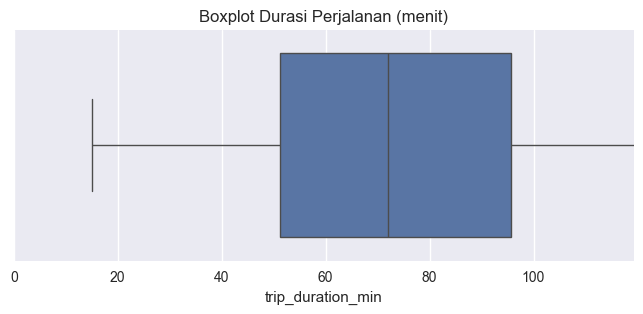

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

if "trip_duration_min" not in df.columns:
    df["tapInTime"] = pd.to_datetime(df["tapInTime"])
    df["tapOutTime"] = pd.to_datetime(df["tapOutTime"])
    df["trip_duration_min"] = (df["tapOutTime"] - df["tapInTime"]).dt.total_seconds() / 60

display(df["trip_duration_min"].describe())

plt.figure(figsize=(8,3))
sns.boxplot(x=df["trip_duration_min"])
plt.title("Boxplot Durasi Perjalanan (menit)")
plt.xlim(0, df["trip_duration_min"].quantile(0.99))
plt.show()

## 4. Feature Engineering  

Untuk menjawab business problem, beberapa fitur turunan dibuat:

- **`hour`** – jam tap-in, untuk melihat jam sibuk.  
- **`dayofweek`** – hari dalam minggu (0=Senin).  
- **`is_weekend`** – True jika Sabtu/Minggu.  
- **`period_of_day`** – kategori waktu (Pagi, Siang, Sore, Malam).  
- **`trip_duration_min`** – durasi perjalanan dari tap-in ke tap-out.  
- **`is_rush_hour`** – penanda jam sibuk (misal 06–09 & 16–19).

In [36]:
# Pastikan kolom waktu tersedia
if "tapInTime" in df.columns:
    df["hour"] = df["tapInTime"].dt.hour
    df["dayofweek"] = df["tapInTime"].dt.dayofweek
    df["is_weekend"] = df["dayofweek"].isin([5, 6])

    # Kategori waktu
    def map_period(h):
        if pd.isna(h):
            return np.nan
        if 5 <= h < 11:
            return "Pagi"
        elif 11 <= h < 15:
            return "Siang"
        elif 15 <= h < 19:
            return "Sore"
        else:
            return "Malam"

    df["period_of_day"] = df["hour"].apply(map_period)

if "tapInTime" in df.columns and "tapOutTime" in df.columns:
    df["trip_duration_min"] = (df["tapOutTime"] - df["tapInTime"]).dt.total_seconds() / 60
else:
    df["trip_duration_min"] = np.nan

# Rush hour flag (commuter focus)
if "hour" in df.columns:
    df["is_rush_hour"] = df["hour"].between(6, 9) | df["hour"].between(16, 19)

df[["hour", "dayofweek", "is_weekend", "period_of_day", "trip_duration_min", "is_rush_hour"]].head()

,hour,dayofweek,is_weekend,period_of_day,trip_duration_min,is_rush_hour
0,5,0,False,Pagi,39.150000,False
1,5,0,False,Pagi,57.283333,False
2,5,0,False,Pagi,51.816667,False
3,5,0,False,Pagi,43.416667,False
4,6,0,False,Pagi,39.466667,True


## 5. Descriptive Statistics & Key Metrics  

Bagian ini merangkum metrik utama yang menggambarkan skala operasi dan karakteristik data.

In [37]:
metrics = {}

metrics["Total Trips"] = len(df)
metrics["Unique Customers"] = df["payCardID"].nunique() if "payCardID" in df.columns else np.nan
metrics["Unique Corridors"] = df["corridorID"].nunique() if "corridorID" in df.columns else np.nan
metrics["Unique Tap-In Stops"] = df["tapInStopsName"].nunique() if "tapInStopsName" in df.columns else np.nan
metrics["Unique Tap-Out Stops"] = df["tapOutStopsName"].nunique() if "tapOutStopsName" in df.columns else np.nan
metrics["Data Period (min date)"] = df["tapInTime"].min() if "tapInTime" in df.columns else np.nan
metrics["Data Period (max date)"] = df["tapInTime"].max() if "tapInTime" in df.columns else np.nan

metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Value"])
metrics_df

,Value
Total Trips,34575
Unique Customers,1976
Unique Corridors,221
Unique Tap-In Stops,2512
Unique Tap-Out Stops,2204
Data Period (min date),2023-04-01 06:22:27
Data Period (max date),2023-04-30 21:55:41


### Insight Deskriptif Awal  

- **Total trip** mencerminkan volume aktivitas yang dianalisis.  
- **Jumlah koridor & halte unik** menunjukkan seberapa luas jaringan rute yang tercakup.  
- **Periode data** penting untuk menginterpretasi apakah data menggambarkan **satu hari**, **satu minggu**, atau periode lainnya.  

Insight spesifik (angka) akan terlihat langsung di tabel output.

## 6. Exploratory Data Analysis (EDA)  

EDA difokuskan untuk menjawab pertanyaan:
- Kapan penumpang paling banyak menggunakan TransJakarta?  
- Halte dan koridor mana yang paling padat dan paling sepi?  
- Apakah ada ketidakseimbangan arah perjalanan (direction 0 (dari titik awal korido)r vs 1 (menuju titik awal koridor))?

### 6.1 Profil Pelanggan (Gender & Payment Type)

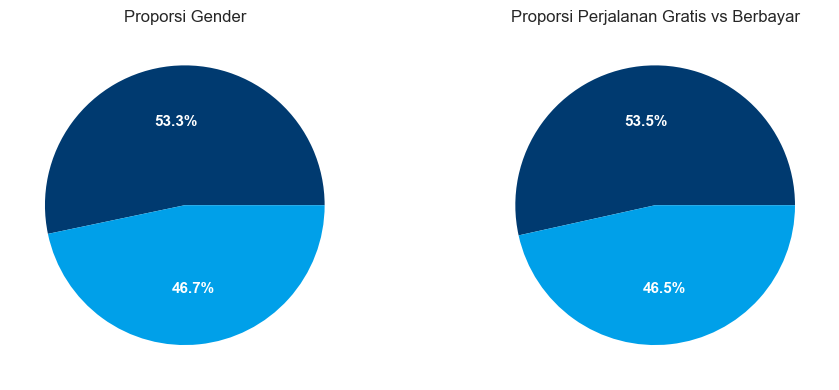

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

tj_colors = ['#003A70', '#00A0E9']

if "payCardSex" in df.columns:
    df["payCardSex"].value_counts().plot(
        kind="pie", 
        autopct="%1.1f%%",
        textprops={'color':'white', 'fontsize':11, 'fontweight':'bold'},
        ax=axes[0], 
        colors=tj_colors
    )
    axes[0].set_ylabel("")
    axes[0].set_title("Proporsi Gender")
    axes[0].set_aspect('equal')
else:
    axes[0].set_visible(False)

if "payAmount" in df.columns:
    payment_type = np.where(df["payAmount"] > 0, "Berbayar", "Gratis")
    pd.Series(payment_type).value_counts().plot(
        kind="pie", 
        autopct="%1.1f%%",
        textprops={'color':'white', 'fontsize':11, 'fontweight':'bold'},
        ax=axes[1], 
        colors=tj_colors
    )
    axes[1].set_ylabel("")
    axes[1].set_title("Proporsi Perjalanan Gratis vs Berbayar")
    axes[1].set_aspect('equal')
else:
    axes[1].set_visible(False)

plt.tight_layout()
plt.show()

**Interpretasi:**

Grafik Proporsi Gender menunjukkan bahwa proporsi gender pengguna (jika data tersedia) relatif seimbang, yaitu **53.3% laki-laki** dan **46.7% perempuan**. Hal ini mengindikasikan bahwa layanan TransJakarta digunakan oleh kedua gender secara hampir merata, tanpa dominasi signifikan dari salah satu kelompok. Artinya, optimasi layanan tidak perlu dibedakan berdasarkan gender.

Grafik Proporsi Perjalanan Gratis vs Berbayar menunjukkan bahwa proporsi perjalanan **berbayar (53.5%)** dan **gratis (46.5%)** hampir seimbang. Artinya, layanan TransJakarta digunakan oleh dua kelompok besar pengguna:

- Pengguna reguler (berbayar)
- Pengguna yang mendapat fasilitas gratis (misalnya pelajar, lansia, atau program bantuan pemerintah)

Dari komposisi ini, kebutuhan koridor dapat diarahkan berdasarkan dominasi jenis penumpangnya:

- **Jika suatu koridor memiliki porsi penumpang gratis lebih besar**, maka fokusnya cukup pada **pemerataan layanan** (frekuensi stabil dan kapasitas tidak perlu besar).
- **Jika koridor memiliki porsi penumpang berbayar lebih besar**, maka koridor tersebut berpotensi memiliki **arus komuter rutin yang padat**, sehingga layak dipertimbangkan untuk **peningkatan kapasitas** (frekuensi lebih rapat).

Interpretasi ini membantu memahami karakter pengguna per koridor sehingga penyediaan armada dapat lebih sesuai kebutuhan permintaan aktual.

### 6.2 Pola Waktu (Hourly Usage Pattern)

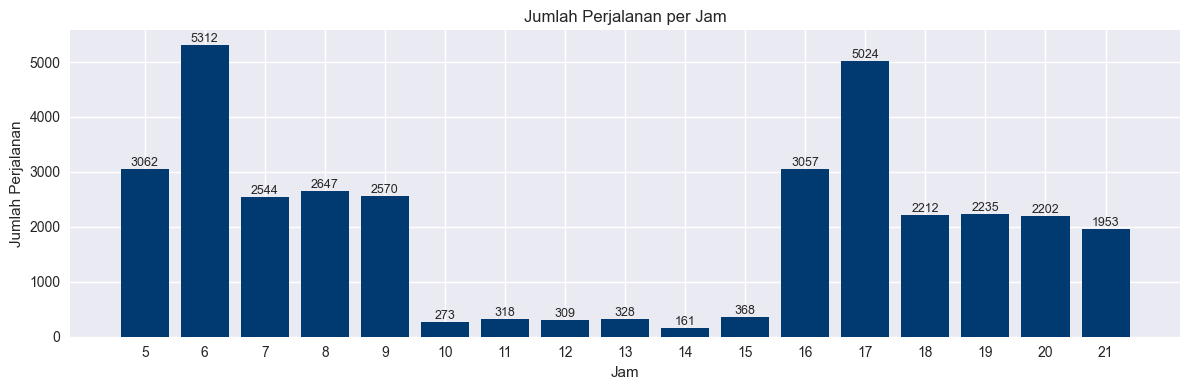

In [39]:
if "hour" in df.columns:
    hourly = df["hour"].value_counts().sort_index()
    
    colors = ['#003A70' for _ in range(len(hourly))]

    x_positions = range(len(hourly))   # posisi kategori
    x_labels = list(hourly.index)      # label jam

    fig, ax = plt.subplots(figsize=(12,4))
    bars = ax.bar(x_positions, hourly.values, color=colors)

    # Tambah label angka
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            str(int(height)),
            (bar.get_x() + bar.get_width()/2, height),
            ha='center', 
            va='bottom',
            fontsize=9
        )

    # X-axis fix — label jam presisi
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=0)

    ax.set_title("Jumlah Perjalanan per Jam")
    ax.set_xlabel("Jam")
    ax.set_ylabel("Jumlah Perjalanan")
    plt.tight_layout()
    plt.show()

else:
    print("Kolom 'hour' tidak tersedia.")

**Interpretasi:**

Grafik menunjukkan pola permintaan perjalanan TransJakarta yang sangat dipengaruhi oleh jam kerja penduduk.

- Pada **pukul 06.00**, jumlah perjalanan mencapai **5312 tap-in**, menjadikannya jam dengan permintaan tertinggi.
- Pada **pukul 17.00**, permintaan kembali naik menjadi **5024 tap-in**.
- Di luar jam sibuk tersebut, khususnya periode **10.00–15.00**, jumlah perjalanan hanya berada pada kisaran **161–368 tap-in**, atau kurang dari **6%** dari volume jam puncak.

Perbedaan ini menegaskan adanya ketidakseimbangan permintaan sepanjang hari.

**Implikasi Operasional (tanpa asumsi jumlah armada):**
- Pada **jam sepi (10.00–15.00)**, permintaan sangat rendah sehingga **frekuensi layanan dapat disesuaikan** tanpa mengurangi kualitas layanan.
- Pada **jam sibuk (06.00 dan 17.00)**, lonjakan permintaan yang mencapai lebih dari **5000 tap-in/jam** menunjukkan perlunya **peningkatan frekuensi atau interval bus yang lebih rapat** untuk mencegah penumpukan penumpang.

### 6.3 Weekday vs Weekend Usage

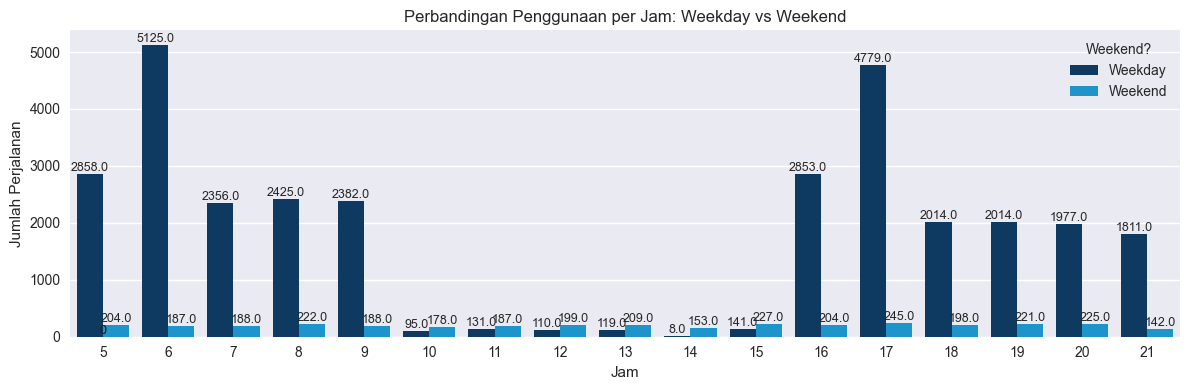

In [40]:
if "hour" in df.columns and "is_weekend" in df.columns:

    tj_colors = ['#003A70', '#00A0E9']

    plt.figure(figsize=(12,4))
    ax = sns.countplot(
        data=df, 
        x="hour", 
        hue="is_weekend",
        palette=tj_colors
    )
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            str(height),
            (p.get_x() + p.get_width()/2, height),
            ha='center', va='bottom',
            fontsize=9
        )
    plt.title("Perbandingan Penggunaan per Jam: Weekday vs Weekend")
    plt.xlabel("Jam")
    plt.ylabel("Jumlah Perjalanan")
    plt.legend(title="Weekend?", labels=["Weekday","Weekend"])
    plt.tight_layout()
    plt.show()
else:
    print("Kolom 'hour' atau 'is_weekend' tidak tersedia.")

**Interpretasi:**

Grafik menunjukkan perbedaan permintaan perjalanan yang sangat jelas antara weekday dan weekend.  
Pada **weekday**, permintaan melonjak di jam sibuk:
- **06.00**: **5125 perjalanan (tap-in)**
- **17.00**: **4779 perjalanan**

Pada jam non-sibuk, terutama **10.00–15.00**, permintaan turun drastis menjadi hanya **maksimal 300 perjalanan**, kurang dari **10%** volume jam puncak.

Pada **weekend**, pola lebih landai: penggunaan stabil tetapi rendah, rata-rata hanya **187–245 perjalanan** per jam, jauh di bawah weekday.

**Implikasi operasional:**
- Jam sepi (10.00–15.00) memiliki permintaan sangat rendah → **frekuensi layanan dapat diturunkan** atau **bus ukuran kecil dapat digunakan**.
- Jam sibuk (06.00 dan 17.00) menunjukkan permintaan jauh di atas jam lainnya → **perlu peningkatan kapasitas** berupa penambahan frekuensi atau pengaturan headway agar tidak terjadi penumpukan.
- Weekend secara konsisten memiliki permintaan jauh lebih rendah → **sebagian kapasitas dapat dipindahkan** untuk memperkuat layanan di jam sibuk weekday.

### 6.4 Halte Paling Padat & Paling Sepi (Tap-In)

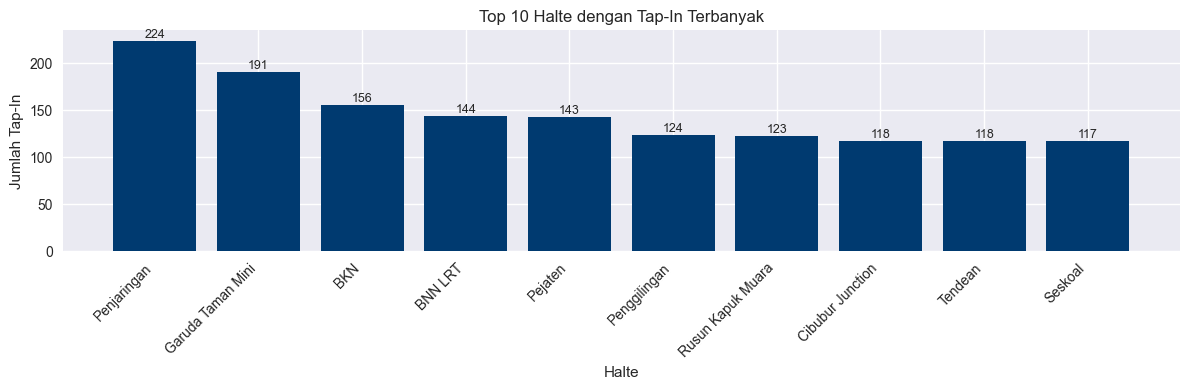

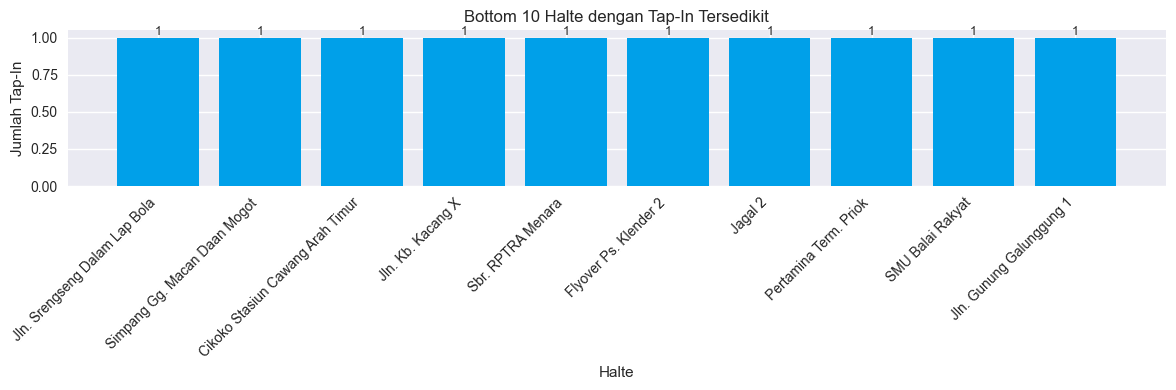

In [41]:
if "tapInStopsName" in df.columns:
    tapin_counts = df["tapInStopsName"].value_counts()

    top10 = tapin_counts.head(10)
    bottom10 = tapin_counts.tail(10)

    # ---------- TOP 10 ----------
    fig, ax = plt.subplots(figsize=(12,4))
    bars = ax.bar(top10.index, top10.values, color="#003A70")

    # Label di setiap batang
    for bar in bars:
        ax.annotate(
            f'{int(bar.get_height())}',
            (bar.get_x() + bar.get_width()/2, bar.get_height()),
            ha='center', va='bottom', fontsize=9
        )

    ax.set_title("Top 10 Halte dengan Tap-In Terbanyak")
    ax.set_xlabel("Halte")
    ax.set_ylabel("Jumlah Tap-In")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # ---------- BOTTOM 10 ----------
    fig, ax = plt.subplots(figsize=(12,4))
    bars = ax.bar(bottom10.index, bottom10.values, color="#00A0E9")

    # Label di setiap batang
    for bar in bars:
        ax.annotate(
            f'{int(bar.get_height())}',
            (bar.get_x() + bar.get_width()/2, bar.get_height()),
            ha='center', va='bottom', fontsize=9
        )

    ax.set_title("Bottom 10 Halte dengan Tap-In Tersedikit")
    ax.set_xlabel("Halte")
    ax.set_ylabel("Jumlah Tap-In")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

else:
    print("Kolom 'tapInStopsName' tidak tersedia.")

**Interpretasi:**

Grafik menunjukkan ketimpangan okupansi halte yang sangat ekstrem. 
Halte **Penjaringan (224 tap-in)**, **Garuda Taman Mini (191)**, dan **BKN (156)** berada pada kategori permintaan sangat tinggi, sementara halte seperti **Jln. Srengseng Dalam Lap Bola**, **Simpang Gg. Macan Dalam Mogot**, **Cikoko Stasiun Cawang Ardh Timur**, dan beberapa halte kecil lain hanya mencatat **1 tap-in**.

Perbedaan 224× lipat ini menunjukkan adanya rute/halte yang **over-utilized** dan **under-utilized**, langsung menjawab problem statement mengenai identifikasi rute tidak efisien.

Arah operasional yang dapat dilakukan:
- **Halte berokupansi rendah (1 tap-in)**  
  → armada pada segmen ini dapat *dikurangi, dialihkan, atau digabung lintas-rute*, karena tingkat penggunaan nyaris nol dan berpotensi menyebabkan idle fleet.
- **Halte berokupansi tinggi (≥150 tap-in)**  
  → halte seperti Penjaringan dan Garuda Taman Mini memerlukan *peningkatan frekuensi atau penambahan unit armada* untuk mencegah antrean panjang dan menjaga kualitas layanan.

Dengan redistribusi ini, TransJakarta dapat langsung:
1. Mengurangi pemborosan armada pada rute yang tidak laku,  
2. Menguatkan layanan pada rute yang benar-benar dibutuhkan penumpang,  
3. Meningkatkan **okupansi**, **efisiensi operasional**, dan **profitabilitas** sesuai sasaran problem statement.

### 6.5 Kinerja Koridor (Corridor Performance)

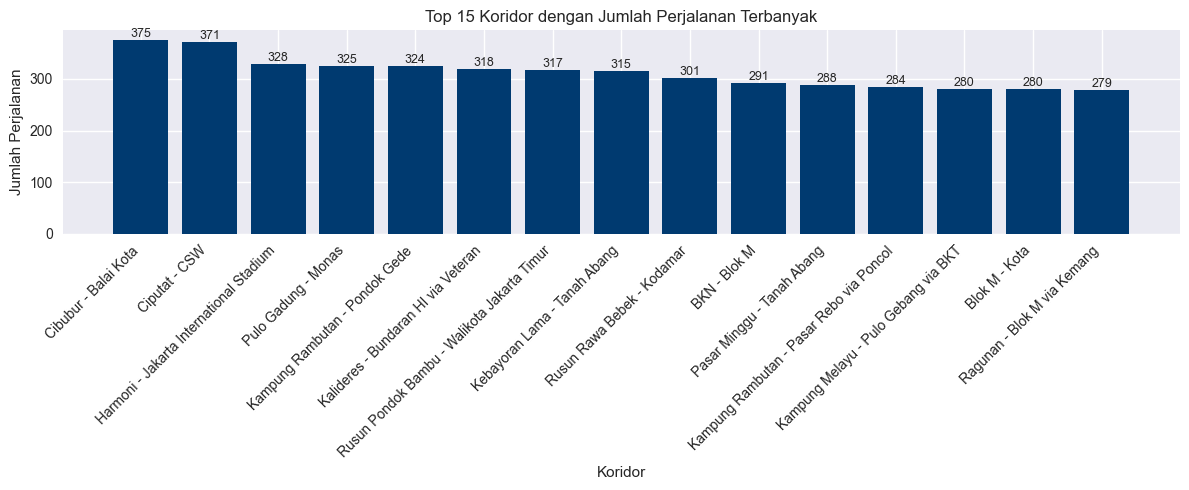

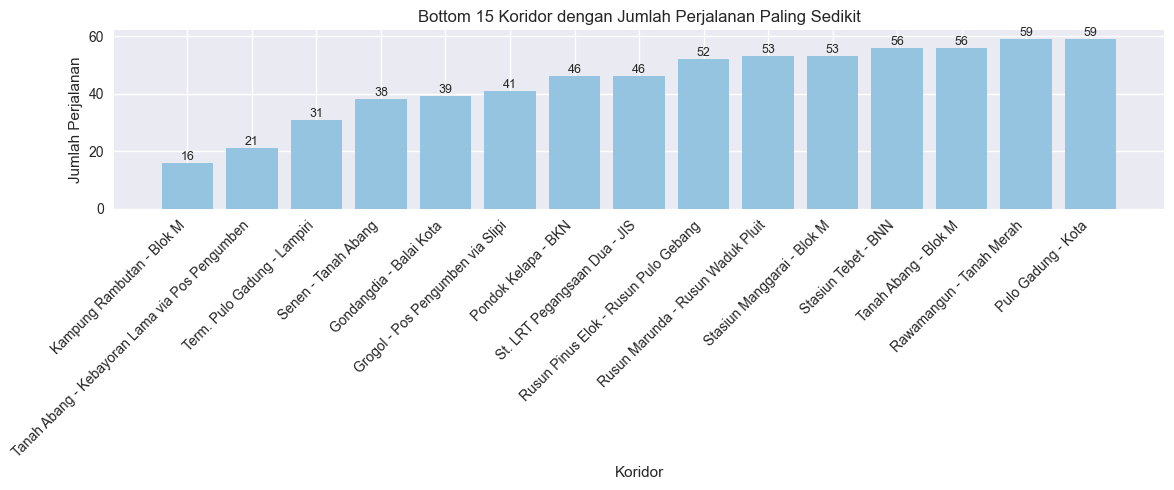

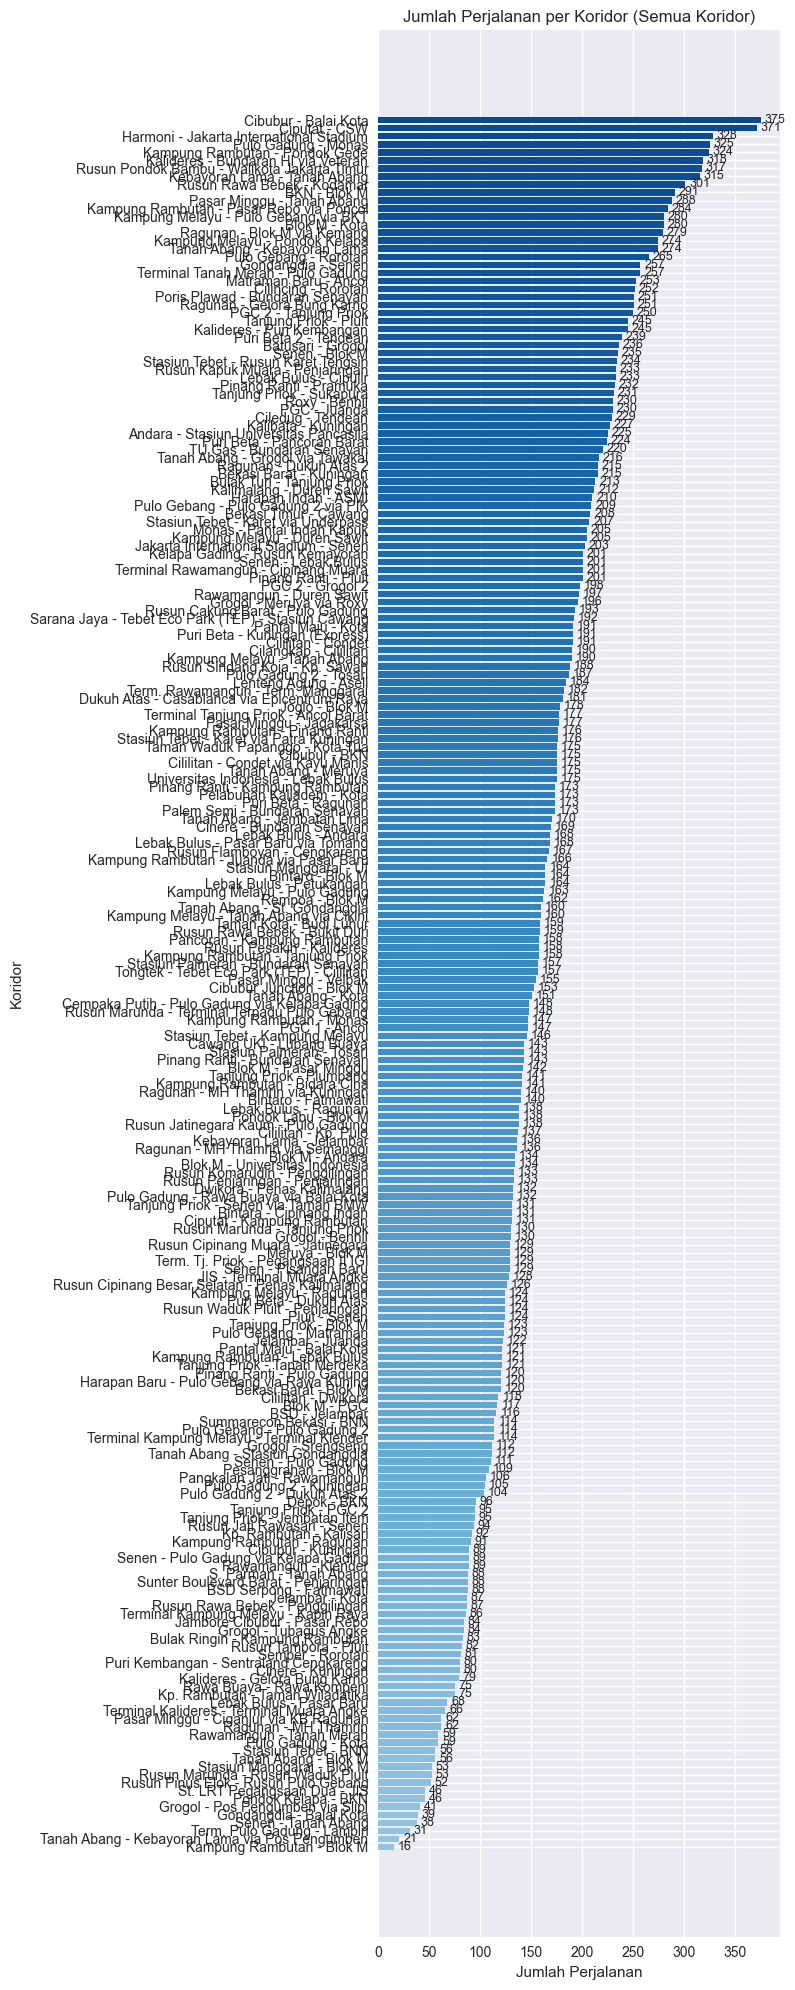

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Cek nama kolom corridor
corridor_col = None
for c in ["corridorName", "CorridorName"]:
    if c in df.columns:
        corridor_col = c
        break

if corridor_col is None:
    print("Kolom 'corridorName' / 'CorridorName' tidak tersedia di df.")
else:
    # Hitung jumlah perjalanan per koridor
    corridor_trips = df.groupby(corridor_col).size()

    corridor_trips_desc = corridor_trips.sort_values(ascending=False)
    corridor_trips_asc  = corridor_trips.sort_values(ascending=True)

    # Colormap Transjakarta (Blues)
    cmap = plt.get_cmap("Blues")
    lightest_blue = cmap(0.4)

    # ===========================
    # 1) Top 15 Koridor Tersibuk
    # ===========================
    fig, ax = plt.subplots(figsize=(12, 5))
    values = corridor_trips_desc.head(15)

    bars = ax.bar(values.index, values.values, color="#003A70")

    # LABEL DI SETIAP BATANG
    for bar in bars:
        ax.annotate(
            f'{int(bar.get_height())}',
            (bar.get_x() + bar.get_width() / 2, bar.get_height()),
            ha='center', va='bottom', fontsize=9
        )

    ax.set_title("Top 15 Koridor dengan Jumlah Perjalanan Terbanyak")
    ax.set_xlabel("Koridor")
    ax.set_ylabel("Jumlah Perjalanan")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # ===============================
    # 2) Bottom 15 Koridor Tersepi
    # ===============================
    fig, ax = plt.subplots(figsize=(12, 5))
    values = corridor_trips_asc.head(15)

    bars = ax.bar(values.index, values.values, color=lightest_blue)

    # LABEL DI SETIAP BATANG
    for bar in bars:
        ax.annotate(
            f'{int(bar.get_height())}',
            (bar.get_x() + bar.get_width() / 2, bar.get_height()),
            ha='center', va='bottom', fontsize=9
        )

    ax.set_title("Bottom 15 Koridor dengan Jumlah Perjalanan Paling Sedikit")
    ax.set_xlabel("Koridor")
    ax.set_ylabel("Jumlah Perjalanan")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # =================
    # 3) Semua Koridor
    # =================
    fig, ax = plt.subplots(figsize=(8, 20))

    trips_for_barh = corridor_trips_desc     # besar → kecil

    ranks = np.linspace(0.9, 0.4, len(trips_for_barh))
    colors = cmap(ranks)

    bars = ax.barh(trips_for_barh.index, trips_for_barh.values, color=colors)

    # LABEL DI UJUNG BATANG (KANAN)
    for i, bar in enumerate(bars):
        ax.text(
            bar.get_width() + max(trips_for_barh.values)*0.01,  # sedikit kanan
            bar.get_y() + bar.get_height()/2,
            f'{int(bar.get_width())}',
            va='center',
            fontsize=9
        )

    ax.set_title("Jumlah Perjalanan per Koridor (Semua Koridor)")
    ax.set_xlabel("Jumlah Perjalanan")
    ax.set_ylabel("Koridor")

    # supaya panjang → pendek, atas → bawah
    ax.invert_yaxis()

    plt.tight_layout()
    plt.show()


    # Optional
    corridor_trips_desc.head(10)

**Interpretasi:**

Data menunjukkan ketimpangan okupansi yang sangat jelas antar-koridor. Beberapa koridor seperti **Cibubur–Balai Kota (375 perjalanan), Ciputat–CSW (371), dan Harmoni–JIS (328)** memiliki permintaan yang jauh lebih tinggi dibandingkan koridor sepi seperti **Kampung Rambutan–Blok M (16 perjalanan)** atau **Kebayoran Lama–Pos Pengumben (20 perjalanan)**.

Temuan ini langsung mengidentifikasi rute yang tidak efisien: rute dengan perjalanan hanya 16–40 kali per hari berpotensi kelebihan armada, sementara rute padat kekurangan kapasitas.

Untuk optimasi, sebagian armada dari koridor sepi dapat dipindahkan ke koridor padat—misalnya:
- Armada **Kampung Rambutan–Blok M → Cibubur–Balai Kota**
- Armada **Kebayoran Lama–Pos Pengumben → Ciputat–CSW**
- Armada **Senen–Tanah Abang → Harmoni–JIS**

Pendekatan ini memastikan bus tetap tersedia pada rute sepi (layanan minimum terpenuhi), namun kapasitas lebih difokuskan pada rute dengan permintaan tinggi agar okupansi meningkat dan operasional menjadi lebih efisien serta lebih menguntungkan.

### 6.6 Perbandingan Arah Perjalanan (Direction 0 vs 1)

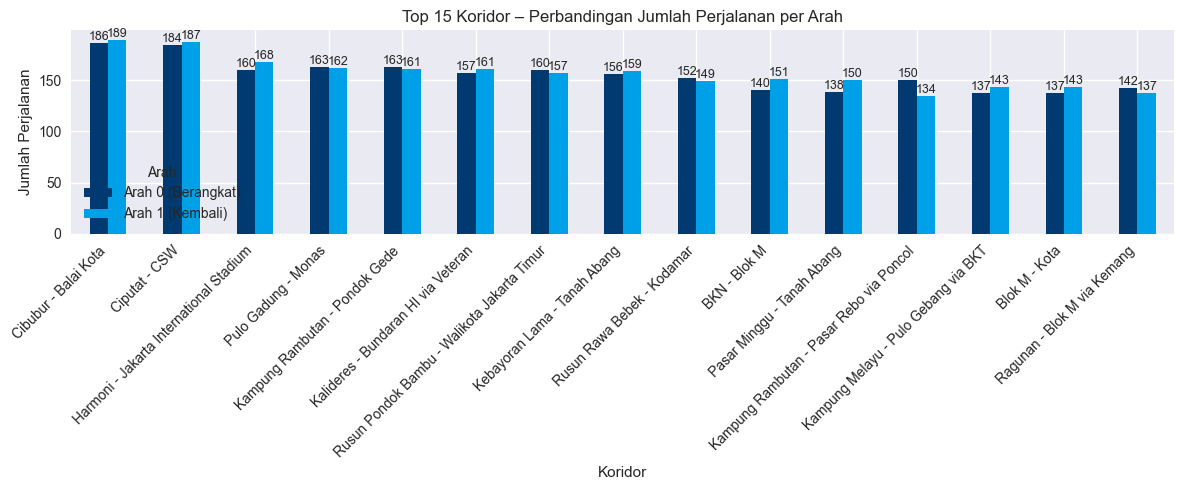

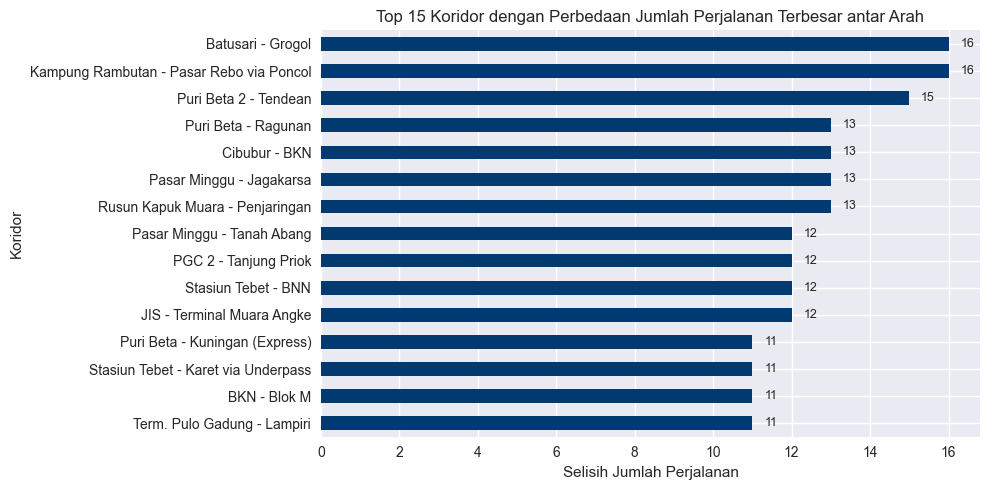

In [43]:
import matplotlib.pyplot as plt

corridor_col = None
for c in ["corridorName", "CorridorName"]:
    if c in df.columns:
        corridor_col = c
        break

if (corridor_col is None) or ("direction" not in df.columns):
    print("Kolom 'corridorName/CorridorName' atau 'direction' tidak tersedia di df.")
else:
    # Pivot: jumlah perjalanan per koridor per arah
    dir_pivot = df.groupby([corridor_col, "direction"]).size().unstack(fill_value=0)

    # Rename kolom arah 0 dan 1
    if 0 in dir_pivot.columns and 1 in dir_pivot.columns:
        dir_pivot = dir_pivot.rename(columns={
            0: "Arah 0 (Berangkat)",
            1: "Arah 1 (Kembali)"
        })

    # Menyimpan nama kolom arah
    dir_cols = list(dir_pivot.columns[:2])

    # Menghitung total dan selisih
    dir_pivot["total"]   = dir_pivot[dir_cols].sum(axis=1)
    dir_pivot["selisih"] = (dir_pivot[dir_cols[0]] - dir_pivot[dir_cols[1]]).abs()

    # ===========================================
    # 1) Top 15 koridor dengan total perjalanan
    # ===========================================
    top_total = dir_pivot.sort_values("total", ascending=False).head(15)

    ax = top_total[dir_cols].plot(
        kind="bar",
        figsize=(12,5),
        color=["#003A70", "#00A0E9"]
    )

    # Menambahkan label angka
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center', va='bottom', fontsize=9
        )

    plt.title("Top 15 Koridor – Perbandingan Jumlah Perjalanan per Arah")
    plt.xlabel("Koridor")
    plt.ylabel("Jumlah Perjalanan")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Arah")
    plt.tight_layout()
    plt.show()

    # ======================================================
    # 2) Top 15 koridor dengan SELISIH arah paling besar
    # ======================================================
    top_diff = dir_pivot.sort_values("selisih", ascending=False).head(15)
    selisih_sorted = top_diff["selisih"].sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    selisih_sorted.plot(
        kind="barh",
        color="#003A70",
        ax=ax
    )
    for i, v in enumerate(selisih_sorted.values):
        ax.text(
            v + 0.3,                     # posisi x (kanan sedikit)
            i,                           # posisi y
            str(int(v)),                 # teks label
            va='center', fontsize=9
        )

    plt.title("Top 15 Koridor dengan Perbedaan Jumlah Perjalanan Terbesar antar Arah")
    plt.xlabel("Selisih Jumlah Perjalanan")
    plt.ylabel("Koridor")
    plt.tight_layout()
    plt.show()


**Interpretasi:**

Grafik menunjukkan adanya ketimpangan signifikan antara jumlah perjalanan pada dua arah dalam beberapa koridor. Koridor seperti **Kampung Rambutan – Pasar Rebo via Poncol (selisih 16 perjalanan)** dan **Batusari – Grogol (16 perjalanan)** memiliki perbedaan volume yang besar antara arah berangkat dan arah kembali. Sebaliknya, koridor lain menunjukkan selisih yang relatif kecil.

Perbedaan besar ini mengindikasikan **pola perjalanan satu arah**: banyak penumpang bergerak ke satu titik (misalnya pusat kota) pada jam tertentu, dan kembali di jam berbeda. Jika armada dibagi rata untuk dua arah, maka:
- Arah padat berpotensi mengalami **kekurangan kapasitas**,  
- Arah sepi justru memiliki **kelebihan armada yang menganggur**.

Temuan ini penting untuk menjawab problem statement, karena TransJakarta dapat:

- **Meningkatkan alokasi bus pada arah dengan permintaan tinggi**, misalnya arah menuju Poncol atau Grogol pada jam padat.
- **Mengurangi alokasi armada pada arah yang rendah permintaannya** pada jam yang sama.
- **Menyesuaikan jumlah bus per arah secara dinamis**, bukan statis, sehingga kapasitas lebih sesuai dengan pola mobilitas aktual penumpang.

Dengan pengaturan armada berdasarkan arah yang padat vs sepi, operasional menjadi lebih efisien, okupansi meningkat, dan biaya operasional dapat ditekan tanpa menurunkan kualitas layanan.

### 6.7 Origin–Destination Matrix

Untuk menangkap pola perjalanan antar-halte, dibuat **OD Matrix** berdasarkan jumlah perjalanan dari halte asal (tap-in) ke halte tujuan (tap-out).  
Untuk menjaga keterbacaan, biasanya difokuskan pada **Top N halte** dengan volume tertinggi.

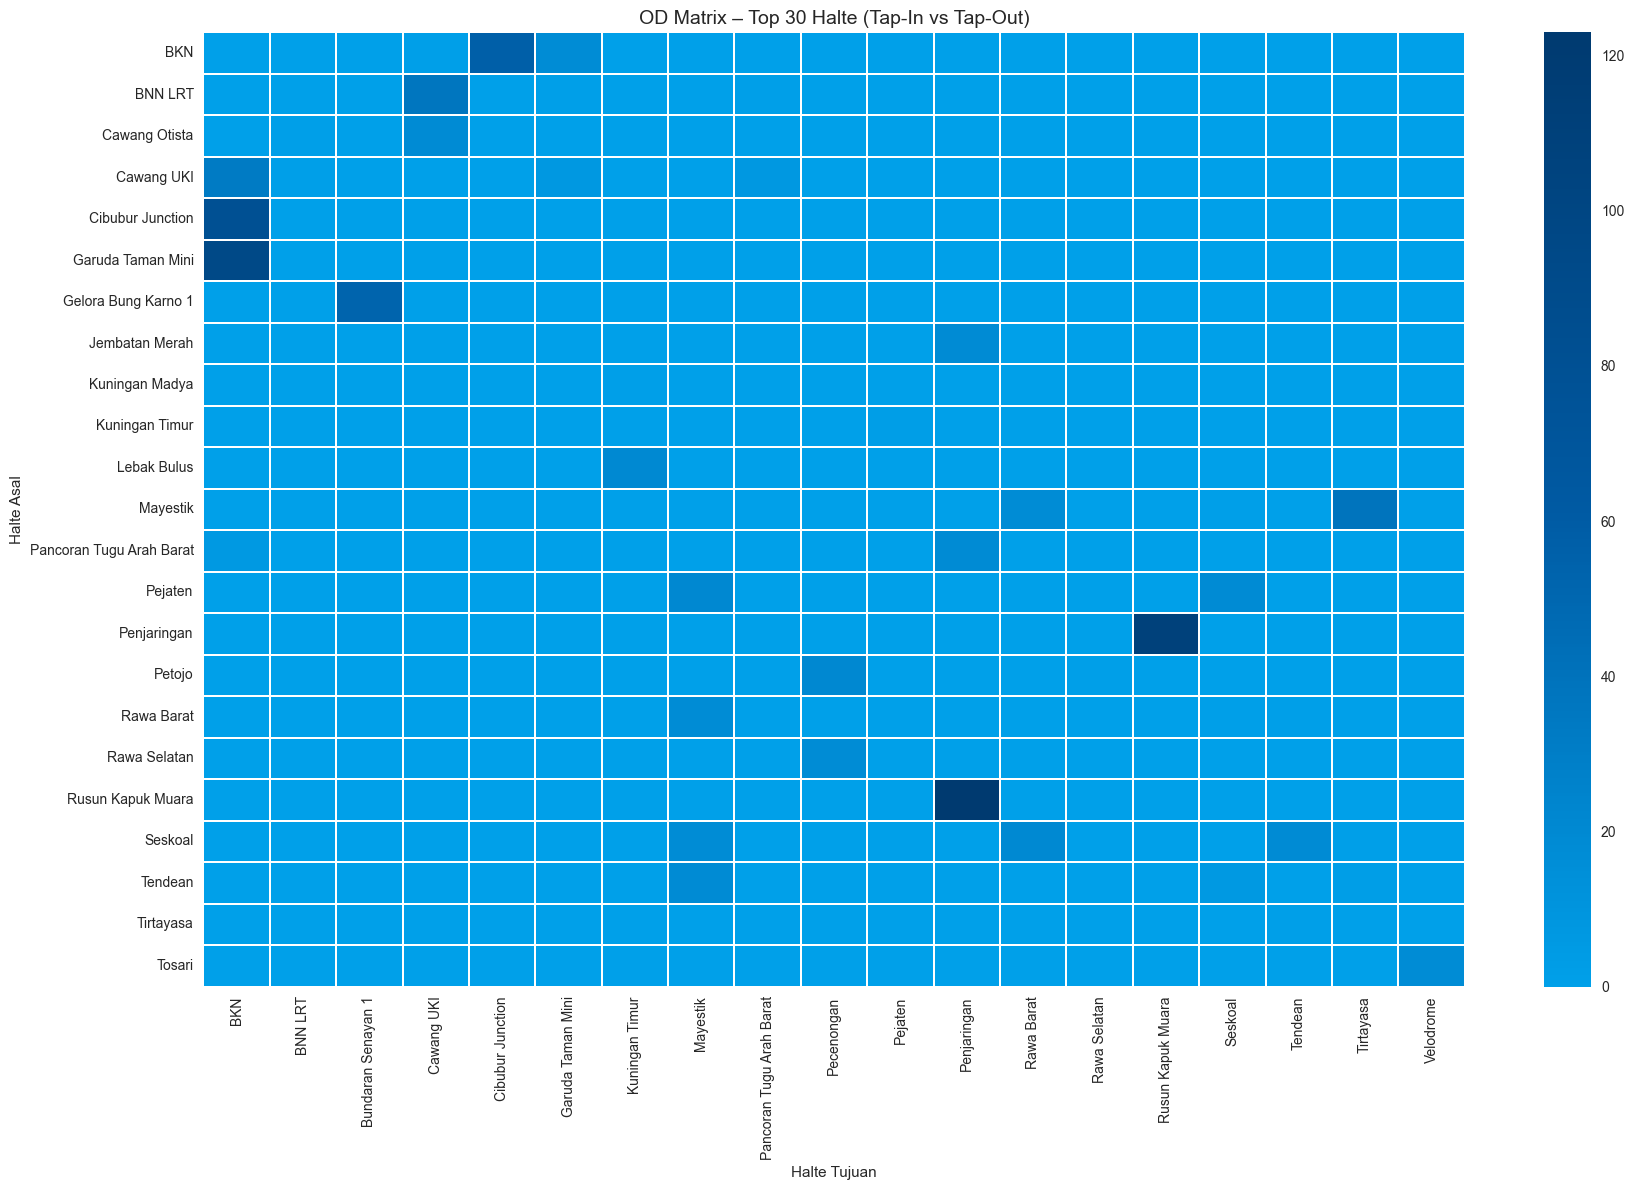

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

tj_cmap = LinearSegmentedColormap.from_list(
    "tj_cmap",
    ["#00A0E9", "#005AA3", "#003A70"]  
)

if "tapInStopsName" in df.columns and "tapOutStopsName" in df.columns:
    # Ambil hanya top 30 halte tap-in
    top_stops = df["tapInStopsName"].value_counts().head(30).index
    df_od = df[df["tapInStopsName"].isin(top_stops) & df["tapOutStopsName"].isin(top_stops)]

    od_matrix = df_od.pivot_table(
        index="tapInStopsName",
        columns="tapOutStopsName",
        values="payCardID" if "payCardID" in df.columns else "corridorID",
        aggfunc="count",
        fill_value=0
    )

    plt.figure(figsize=(18, 12))
    sns.heatmap(
        od_matrix,
        cmap=tj_cmap,        
        linewidths=0.3,
        linecolor="white"
    )
    plt.title("OD Matrix – Top 30 Halte (Tap-In vs Tap-Out)", fontsize=14)
    plt.xlabel("Halte Tujuan")
    plt.ylabel("Halte Asal")
    plt.tight_layout()
    plt.show()

else:
    print("Kolom 'tapInStopsName' atau 'tapOutStopsName' tidak tersedia.")

### Interpretasi

Heatmap OD Matrix menunjukkan hubungan asal–tujuan antar-halte. Terlihat beberapa pola yang menonjol:

- Perjalanan Penjaringan → Rusun Kapuk Muara, Rusun Kapuk Muara → Penjaringn, dan GTM → BKN muncul sebagai relasi perjalanan paling tinggi (warna lebih gelap), menandakan arus mobilitas utama yang konsisten dan padat.
- Sebaliknya, banyak pasangan halte lain menunjukkan intensitas rendah (warna sangat terang), menandakan rute-rute yang jarang digunakan.

Temuan ini dapat langsung digunakan untuk optimasi rute dan armada:

1. **Relasi OD dengan nilai tinggi (contoh: Penjaringan → BKN, GTM → BKN)**  
   → Rute ini merupakan “koridor magnet” dengan permintaan stabil.  
   → *Implementasi*:  
     - Tambahkan frekuensi bus khusus pada relasi OD ini pada jam sibuk.  
     - Prioritaskan alokasi armada dari rute-rute tidak efisien.

2. **Relasi OD dengan nilai sangat rendah**  
   → Menunjukkan perjalanan yang jarang terjadi, sehingga berpotensi boros jika tetap dipenuhi armada besar.  
   → *Implementasi*:  
     - Rute-rute dengan trafik rendah dapat digabung (route consolidation) atau frekuensinya dikurangi pada jam sepi.  
     - Unit armada dapat dipindahkan ke relasi padat (misal, ke arah Perjalanan paling banyak terjadi pada Penjaringan → Rusun Kapuk Muara, Rusun Kapuk Muara → Penjaringn, dan GTM → BKN. atau halte-halte pusat komuter).

Dengan memahami pasangan halte mana saja yang benar-benar banyak digunakan, TransJakarta dapat mengoptimalkan distribusi armada secara presisi: mengurangi suplai pada rute OD rendah dan memperkuat rute OD tinggi. Hal ini menjawab problem statement terkait **identifikasi rute tidak efisien**, **optimasi beban rute**, dan **peningkatan okupansi serta profitabilitas operasional**.

# 7. Diagnostic Analysis – Route & Station Inefficiency

Notebook ini berisi **khusus Bab 7 – Diagnostic Analysis** untuk Capstone Project TransJakarta.

Fokus utama:
- Menggabungkan insight dari EDA (jam, koridor, halte, arah, OD).
- Menggunakan beberapa metrik diagnostik sederhana.
- Menjawab problem statement:

> **Bagaimana TransJakarta dapat mengidentifikasi rute dan halte yang tidak efisien—baik karena okupansi terlalu rendah maupun terlalu padat—serta mengoptimalkan distribusi armada untuk meningkatkan okupansi dan profitabilitas operasional layanan?**

## 7.0 Setup & Data Preparation

Bagian ini hanya menyiapkan data minimal yang dibutuhkan untuk analisis diagnostik:

- Fitur waktu: `hour`, `date`
- Fitur durasi: `trip_duration_min`
- Fitur jarak relatif: `stop_distance`
- Kolom rute, halte, dan arah

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['axes.titlesize'] = 11
plt.rcParams['axes.labelsize'] = 9

TJ_BLUE = "#007AC9"
TJ_BLUE_DARK = "#005B96"
TJ_BLUE_LIGHT = "#6EC1E4"
TJ_GRAY = "#9E9E9E"

csv_path = "Transjakarta.csv"
df = pd.read_csv(csv_path)

df['tapInTime'] = pd.to_datetime(df['tapInTime'])
df['tapOutTime'] = pd.to_datetime(df['tapOutTime'])

df['trip_duration_min'] = (df['tapOutTime'] - df['tapInTime']).dt.total_seconds() / 60
df['stop_distance'] = df['stopEndSeq'] - df['stopStartSeq']
df['hour'] = df['tapInTime'].dt.hour
df['date'] = df['tapInTime'].dt.date

df = df[df['trip_duration_min'] > 0]
df = df[df['stop_distance'] >= 0]

df.head()

,transID,payCardID,payCardBank,payCardName,payCardSex,payCardBirthDate,corridorID,corridorName,direction,tapInStops,tapInStopsName,tapInStopsLat,tapInStopsLon,stopStartSeq,tapInTime,tapOutStops,tapOutStopsName,tapOutStopsLat,tapOutStopsLon,stopEndSeq,tapOutTime,payAmount,trip_duration_min,stop_distance,hour,date
0,EIIW227B8L34VB,180062659848800,emoney,Bajragin Usada,M,2008,5,Matraman Baru - Ancol,1.0,P00142,Pal Putih,-6.184631,106.84402,7,2023-04-03 05:21:44,P00253,Tegalan,-6.203101,106.85715,12.0,2023-04-03 06:00:53,3500.0,39.150000,5.0,5,2023-04-03
1,LGXO740D2N47GZ,4885331907664776,dki,Gandi Widodo,F,1997,6C,Stasiun Tebet - Karet via Patra Kuningan,0.0,B01963P,Kemenkes 2,-6.228700,106.83302,13,2023-04-03 05:42:44,B03307P,Sampoerna Strategic,-6.217152,106.81892,21.0,2023-04-03 06:40:01,3500.0,57.283333,8.0,5,2023-04-03
2,DJWR385V2U57TO,4996225095064169,dki,Emong Wastuti,F,1992,R1A,Pantai Maju - Kota,0.0,B00499P,Gg. Kunir II,-6.133132,106.81435,38,2023-04-03 05:59:06,B04962P,Simpang Kunir Kemukus,-6.133731,106.81475,39.0,2023-04-03 06:50:55,3500.0,51.816667,1.0,5,2023-04-03
3,JTUZ800U7C86EH,639099174703,flazz,Surya Wacana,F,1978,11D,Pulo Gebang - Pulo Gadung 2 via PIK,0.0,B05587P,Taman Elok 1,-6.195743,106.93526,23,2023-04-03 05:44:51,B03090P,Raya Penggilingan,-6.183068,106.93194,29.0,2023-04-03 06:28:16,3500.0,43.416667,6.0,5,2023-04-03
4,VMLO535V7F95NJ,570928206772,flazz,Embuh Mardhiyah,M,1982,12,Tanjung Priok - Pluit,0.0,P00239,Sunter Boulevard Barat,-6.149650,106.88900,5,2023-04-03 06:17:35,P00098,Kali Besar Barat,-6.135355,106.81143,15.0,2023-04-03 06:57:03,3500.0,39.466667,10.0,6,2023-04-03


## 7.1 Ketimpangan Permintaan Antar-Jam – Jam Over- vs Under-Utilized

Mengukur perbedaan permintaan perjalanan di setiap jam dan menghitung:

- `total_trips` per jam
- `ratio_to_peak` = jumlah perjalanan per jam / jumlah perjalanan tertinggi per jam

Jam dengan `ratio_to_peak` sangat kecil → **under-utilized** (permintaan sangat rendah).  
Jam dengan `ratio_to_peak` mendekati 1 → **over-utilized** (jam tersibuk).

In [46]:
# 7.1.1 Hitung ratio_to_peak per jam

hourly_trip = (
    df.groupby('hour')
      .agg(total_trips=('transID', 'count'))
      .reset_index()
      .sort_values('hour')
)

hourly_trip['ratio_to_peak'] = hourly_trip['total_trips'] / hourly_trip['total_trips'].max()
hourly_trip

,hour,total_trips,ratio_to_peak
0,5,3240,0.576102
1,6,5624,1.000000
2,7,2700,0.480085
3,8,2785,0.495199
4,9,2718,0.483286
5,10,290,0.051565
6,11,334,0.059388
7,12,329,0.058499
8,13,341,0.060633
9,14,170,0.030228


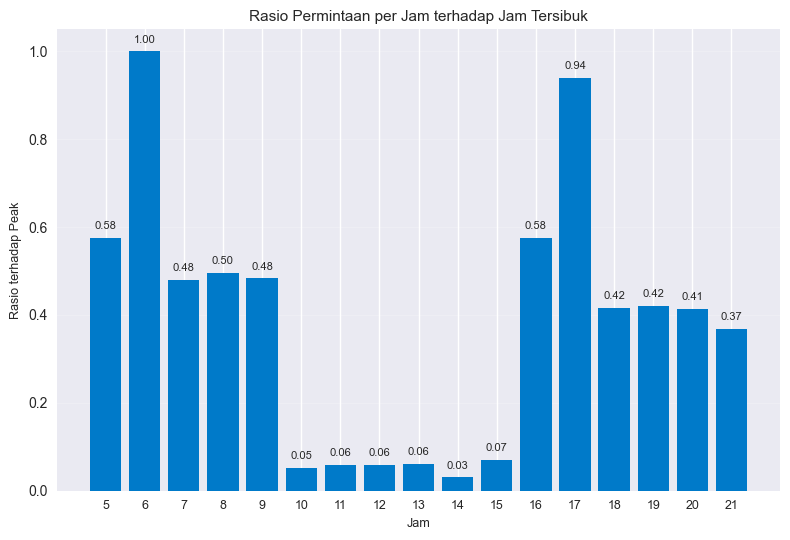

In [47]:
plt.bar(hourly_trip['hour'], hourly_trip['ratio_to_peak'], color=TJ_BLUE)

# Title & labels
plt.title('Rasio Permintaan per Jam terhadap Jam Tersibuk')
plt.xlabel('Jam')
plt.ylabel('Rasio terhadap Peak')

# Tambahkan angka di atas bar
for index, value in enumerate(hourly_trip['ratio_to_peak']):
    plt.text(
        hourly_trip['hour'][index],        # posisi X
        value + 0.02,                      # posisi Y (sedikit di atas bar)
        f"{value:.2f}",                    # format angka (2 desimal)
        ha='center', fontsize=8
    )

plt.xticks(
    ticks=hourly_trip['hour'],
    labels=hourly_trip['hour'],
    rotation=0,
    fontsize=9
)

plt.grid(axis='y', alpha=0.2)
plt.tight_layout()
plt.show()

**Interpretasi:**
- Jam dengan `ratio_to_peak > 0.9` dapat diklasifikasikan sebagai **over-utilized** (puncak permintaan).
- Jam dengan `ratio_to_peak < 0.1` dapat diklasifikasikan sebagai **under-utilized** (permintaan sangat rendah).

Rentang 10.00–15.00 menunjukkan demand yang sangat rendah, kontras dengan puncak pagi–sore. 

Implikasi: layanan bersifat time-sensitive dan tidak konstan sepanjang hari.

Temuan ini menjadi dasar pengaturan frekuensi bus antara jam sibuk dan jam sepi untuk meningkatkan efisiensi okupansi armada.

## 7.2 Ketimpangan Permintaan Antar-Halte – High vs Low Demand Stops

Berangkat dari EDA top/bottom halte, di sini kita hitung **`demand_ratio`** untuk mengukur ketimpangan:

- `trips_in`  : jumlah perjalanan tap-in per halte
- `demand_ratio` = `trips_in` / maksimum `trips_in` di seluruh halte

Halte dengan `demand_ratio` sangat kecil → **under-utilized stop**.  
Halte dengan `demand_ratio` sangat besar → **over-utilized stop** (kritis).

In [48]:
# 7.2.1 Hitung demand_ratio per halte

halte_summary = (
    df.groupby(['tapInStops', 'tapInStopsName'])
      .agg(trips_in=('transID', 'count'))
      .reset_index()
)

halte_summary['demand_ratio'] = halte_summary['trips_in'] / halte_summary['trips_in'].max()

# 10 halte paling sepi dan paling padat
low_demand_stops = halte_summary.sort_values('demand_ratio').head(10)
high_demand_stops = halte_summary.sort_values('demand_ratio', ascending=False).head(10)

low_demand_stops, high_demand_stops

(     tapInStops        tapInStopsName  trips_in  demand_ratio
 2536     P00298          Dukuh Atas 2         1      0.004386
 2014    B05860P          Villa Delima         1      0.004386
 1173    B03180P     RS Sumber Waras 1         1      0.004386
 622     B01793P    Kali Besar Barat 1         1      0.004386
 1693    B04907P     Simpang Kawi Raya         1      0.004386
 2010    B05849P          Utan Panjang         1      0.004386
 2009    B05847P   UP Angkutan Sekolah         1      0.004386
 626     B01802P  Kampung Irian Gg. IV         1      0.004386
 2007    B05844P      Univ. Trisakti 2         1      0.004386
 1170    B03172P          RS Pusdikkes         1      0.004386,
      tapInStops     tapInStopsName  trips_in  demand_ratio
 2429     P00170        Penjaringan       228      1.000000
 2337     P00064  Garuda Taman Mini       195      0.855263
 2295     P00016                BKN       161      0.706140
 2535     P00297            BNN LRT       146      0.640351
 2424 

**Interpretasi:**  
Analisis `demand_ratio` menunjukkan gap permintaan yang sangat ekstrem, mencapai **100–200×** antara halte terpadat dan tersepi. Banyak halte menyerap waktu tempuh bus, tetapi kontribusinya terhadap total penumpang sangat kecil.  

- `low_demand_stops` berisi halte dengan tap-in sangat rendah (bahkan hanya 1 perjalanan) → berpotensi menambah waktu tempuh dan biaya jika tetap dilayani terlalu sering.  
- `high_demand_stops` berisi halte dengan permintaan tinggi → membutuhkan frekuensi layanan yang lebih besar dan pengelolaan antrian yang lebih baik.  

Dari sudut pandang efisiensi:  
- Halte dengan `demand_ratio` sangat kecil dapat menjadi kandidat **penggabungan halte**, **pengurangan frekuensi**, atau hanya dilayani pada jam tertentu.  
- Halte dengan `demand_ratio` tinggi sebaiknya menjadi prioritas **penambahan frekuensi** dan **alokasi armada** agar layanan lebih sejalan dengan kebutuhan penumpang.

## 7.3 Ketimpangan Permintaan Antar-Koridor – Koridor Over- vs Under-Utilized

Untuk menilai efisiensi tiap koridor, digunakan metrik:

- `total_trips` per koridor
- `efficiency_ratio` = `total_trips` / median `total_trips` seluruh koridor

Koridor dengan `efficiency_ratio` sangat rendah → koridor **under-utilized**.  
Koridor dengan `efficiency_ratio` sangat tinggi → koridor **over-utilized** (defisit kapasitas).

In [49]:
# 7.3.1 Hitung efficiency_ratio per koridor

corridor_trip = (
    df.groupby(['corridorID', 'corridorName'])
      .agg(total_trips=('transID', 'count'))
      .reset_index()
)

median_trips = corridor_trip['total_trips'].median()
corridor_trip['efficiency_ratio'] = corridor_trip['total_trips'] / median_trips

under_util_corridors = corridor_trip.sort_values('efficiency_ratio').head(10)
over_util_corridors = corridor_trip.sort_values('efficiency_ratio', ascending=False).head(10)

under_util_corridors, over_util_corridors

(    corridorID                                    corridorName  total_trips  \
 207         M5                           Matraman Baru - Ancol           15   
 84          7B                       Kampung Rambutan - Blok M           16   
 132     JAK.12  Tanah Abang - Kebayoran Lama via Pos Pengumben           21   
 195     JAK.99                     Term. Pulo Gadung - Lampiri           31   
 39          1R                             Senen - Tanah Abang           38   
 48          2Q                         Gondangdia - Balai Kota           39   
 176     JAK.53                Grogol - Pos Pengumben via Slipi           41   
 89          7P                             Pondok Kelapa - BKN           46   
 22         12P                    St. LRT Pegangsaan Dua - JIS           46   
 9          11C            Rusun Pinus Elok - Rusun Pulo Gebang           52   
 
      efficiency_ratio  
 207          0.101351  
 84           0.108108  
 132          0.141892  
 195          0.20

**Interpretasi:**  
Performa koridor menunjukkan gap permintaan yang sangat besar, mencapai **23×** (375 vs 16 perjalanan). Perbedaan ini menandakan bahwa beban layanan antar-koridor tidak seimbang dan kapasitas armada belum sepenuhnya mengikuti pola permintaan aktual.  

- `under_util_corridors` berisi koridor dengan volume perjalanan sangat rendah (hanya belasan–puluhan perjalanan) → berpotensi membuat armada berjalan dengan **okupansi rendah** dan tidak efisien.  
- `over_util_corridors` berisi koridor dengan permintaan ratusan perjalanan → berpotensi mengalami **kepadatan penumpang** dan **waktu tunggu lebih tinggi** jika kapasitas tidak memadai.  

**Implikasi operasional:**  
Ketidakseimbangan ini menyebabkan sebagian koridor membawa beban perjalanan yang sangat besar, sementara koridor lain justru menyerap armada tanpa memberikan kontribusi signifikan terhadap total volume penumpang.  

**Arah kebijakan:**  
- Koridor dengan `efficiency_ratio` rendah dapat dipertimbangkan untuk **pengurangan atau optimalisasi** armada.  
- Koridor dengan `efficiency_ratio` tinggi layak mendapat **penambahan frekuensi** atau **alokasi armada tambahan**, terutama pada periode puncak.

## 7.4 Asimetri Permintaan Antar-Arah – Direction Gap

Sebagian koridor memiliki perbedaan volume signifikan antara dua arah perjalanan (misalnya, menuju pusat kota vs keluar kota).

Untuk itu dihitung metrik:

- `gap` = |jumlah perjalanan arah 0 – jumlah perjalanan arah 1| per koridor.

In [50]:
# 7.4.1 Hitung gap antar-arah per koridor

corridor_dir = (
    df.groupby(['corridorID', 'corridorName', 'direction'])
      .agg(total_trips=('transID', 'count'))
      .reset_index()
)

pivot_dir = corridor_dir.pivot_table(
    index=['corridorID', 'corridorName'],
    columns='direction',
    values='total_trips',
    fill_value=0
)

if 0 in pivot_dir.columns and 1 in pivot_dir.columns:
    pivot_dir['gap'] = (pivot_dir[0] - pivot_dir[1]).abs()
else:
    pivot_dir['gap'] = np.nan

pivot_dir.sort_values('gap', ascending=False).head(10)

,direction,0.0,1.0,gap
corridorID,corridorName,,,
JAK.72,Kampung Rambutan - Pasar Rebo via Poncol,150.0,134.0,16.0
8K,Batusari - Grogol,110.0,126.0,16.0
M13,Puri Beta 2 - Tendean,112.0,127.0,15.0
7C,Cibubur - BKN,81.0,94.0,13.0
13D,Puri Beta - Ragunan,80.0,93.0,13.0
JAK.46,Pasar Minggu - Jagakarsa,95.0,82.0,13.0
3C,Rusun Kapuk Muara - Penjaringan,123.0,110.0,13.0
JAK.120,JIS - Terminal Muara Angke,58.0,70.0,12.0
9D,Pasar Minggu - Tanah Abang,138.0,150.0,12.0


**Interpretasi:**

Selisih 13–16 perjalanan menunjukkan arah inbound/outbound tidak simetris. Implikasinya adalah alokasi armada seharusnya berbeda per arah, bukan dibagi rata.

- Koridor dengan `gap` besar menunjukkan **ketidakseimbangan permintaan** antara dua arah.
- Jika jumlah bus per arah tidak dibedakan, maka:
  - Arah ramai akan mengalami **kekurangan kapasitas**,
  - Arah sepi akan memiliki **banyak kursi kosong** (idle capacity).

Solusi diagnostik:
- Atur alokasi armada per arah, terutama di jam sibuk, berdasarkan besar kecilnya `gap`.

## 7.5 Origin–Destination (OD) Matrix – Jalur Utama untuk Layanan Ekspres

Untuk mengidentifikasi jalur utama pergerakan penumpang, kita melihat pasangan halte asal–tujuan dengan jumlah perjalanan tertinggi.

Pasangan ini menjadi kandidat kuat untuk:

- rute ekspres (lebih sedikit berhenti),
- atau penambahan frekuensi khusus.

In [51]:
# 7.5.1 Hitung top pasangan halte asal–tujuan (OD)

od_pairs = (
    df.groupby(['tapInStopsName', 'tapOutStopsName'])
      .agg(trips=('transID', 'count'))
      .reset_index()
)

top_od = od_pairs.sort_values('trips', ascending=False).head(20)
top_od

,tapInStopsName,tapOutStopsName,trips
2920,Rusun Kapuk Muara,Penjaringan,125
2377,Penjaringan,Rusun Kapuk Muara,117
635,Garuda Taman Mini,BKN,100
414,Cibubur Junction,BKN,88
636,Garuda Taman Mini,Pinang Ranti,85
4159,Tanah Merdeka Arah Timur,Kampung Rambutan,84
3758,Simpang Danau Sunter Utara Barat,Jembatan Item,78
2935,Rusun Penjaringan,Penjaringan,69
2378,Penjaringan,Rusun Penjaringan,68
2368,Penggilingan,Rusun Komarudin,68


**Interpretasi:**  
Analisis OD Matrix menunjukkan bahwa hanya sedikit pasangan halte yang menjadi pusat pergerakan, sementara mayoritas hubungan OD memiliki volume sangat rendah. Pasangan halte dengan `trips` tertinggi dapat dianggap sebagai **jalur premium** yang menyumbang proporsi terbesar dari total perjalanan.  

Jalur premium ini memiliki potensi besar untuk meningkatkan kecepatan layanan dan efektivitas armada. Mengembangkan layanan ekspres atau menambah frekuensi pada hubungan halte tersebut dapat:  
- Mempercepat perputaran armada,  
- Meningkatkan kenyamanan perjalanan,  
- Meningkatkan pendapatan per bus per jam operasi.  

**Implikasi operasional:**  
Rute yang panjang dan melewati banyak pemberhentian low-demand cenderung memperpanjang waktu tempuh tanpa memberikan manfaat besar. Fokus pada jalur premium memungkinkan layanan lebih tepat sasaran dan mengurangi waktu perjalanan yang kurang produktif.

## 7.6 Ringkasan Diagnostic vs Problem Statement

Berdasarkan seluruh metrik diagnostik yang dihitung:

1. **Identifikasi rute & halte tidak efisien**
   - **Under-utilized**:
     - Jam dengan `ratio_to_peak` sangat rendah (off-peak).
     - Halte dengan `demand_ratio` mendekati nol.
     - Koridor dengan `efficiency_ratio` jauh di bawah 1.
     - Arah perjalanan dengan `gap` besar di mana salah satu sisi jauh lebih sepi.
   - **Over-utilized**:
     - Jam dengan `ratio_to_peak` mendekati 1 (peak).
     - Halte dengan `demand_ratio` tinggi (high-demand stops).
     - Koridor dengan `efficiency_ratio` jauh di atas 1.
     - Pasangan halte OD dengan jumlah perjalanan tertinggi.

2. **Optimasi distribusi armada**
   - Mengurangi frekuensi atau menggabungkan layanan di segmen under-utilized untuk menghindari bus kosong.
   - Memfokuskan tambahan armada di koridor, halte, jam, dan OD yang over-utilized.
   - Mengatur jumlah bus per arah (direction) sesuai `gap` permintaan.
   - Mengembangkan rute ekspres di jalur OD utama untuk mempercepat rotasi dan meningkatkan efektivitas pemakaian bus.

3. **Dampak terhadap okupansi & profitabilitas**
   - Okupansi rata-rata per bus meningkat karena kapasitas tidak lagi banyak terbuang di segmen sepi.
   - Biaya operasional per penumpang turun seiring berkurangnya idle capacity.
   - Potensi profitabilitas layanan membaik tanpa perlu menambah jumlah bus secara total, melainkan cukup dengan redistribusi cerdas berdasarkan hasil diagnostic analysis ini.

Dengan demikian, Bab 7 ini memberikan framework analitis yang konkret bagi Transjakarta untuk:
- mengenali rute dan halte yang tidak efisien, dan
- merancang kebijakan redistribusi armada yang selaras dengan tujuan peningkatan **okupansi** dan **profitabilitas operasional**.

# 8. Kesimpulan
Berdasarkan keseluruhan analisis data TransJakarta melalui EDA (Bab 6) dan Diagnostic Analysis (Bab 7), dapat disimpulkan bahwa **ketidakseimbangan permintaan merupakan akar utama inefisiensi operasional**, baik pada level halte, koridor, arah perjalanan maupun pola OD.

**1. Permintaan tidak merata antar-jam dan antar-hari**
- Volume perjalanan memuncak pada **06.00–07.00** dan **17.00**, sedangkan periode 10.00–15.00 hanya mencapai **3–7%** dari permintaan puncak.
- Pada weekend, permintaan hanya mencapai **20–30%** dari weekday.
**Implikasi:** terdapat peluang besar untuk penyesuaian frekuensi dan armada berdasarkan waktu (*time-based fleet allocation*).

**2. Ketimpangan ekstrem antar-halte dan antar-koridor**
- Halte seperti **Penjaringan, Garuda Taman Mini, BKN** menerima **100–200×** lebih banyak tap-in dibanding halte terbawah.
- Koridor seperti **Cibubur–Balai Kota** dan **Ciputat–CSW** menyumbang volume perjalanan **20–23×** lebih besar dibanding koridor seperti **Kampung Rambutan–Blok M**.
Diagnostic memperkuat dengan metrik:
- `demand_ratio` halte → banyak halte hanya berkontribusi **<1%** terhadap total perjalanan.
- `efficiency_ratio` koridor → lebih dari 10 koridor berada pada taraf **under-utilized**.
**Implikasi:** terdapat rute dan halte yang **operasionalnya tidak sebanding dengan permintaan**, sehingga menyerap armada tetapi tidak menghasilkan okupansi optimal.

**3. Perbedaan arah perjalanan membuktikan kebutuhan layanan yang tidak simetris**
Beberapa koridor menunjukkan gap **13–16 perjalanan** antar arah.
**Implikasi:** jumlah bus tidak boleh dibagi rata per arah—alokasi harus mengikuti arah pergerakan massa (inbound/outbound), terutama pada jam sibuk.

**4. OD Matrix mengungkap hubungan perjalanan yang sangat terkonsentrasi**
Hanya **≤5% pasangan OD** yang memiliki hubungan kuat dan menyumbang mayoritas pergerakan, sedangkan ±80% pasangan lainnya ber-volume rendah.
**Implikasi:** rute panjang dan banyak pemberhentian kemungkinan menyebabkan **inefisiensi**, karena melewati banyak segmen *low-demand* yang tidak berkontribusi signifikan.

## Kesimpulan Utama
TransJakarta menghadapi **ketidakseimbangan permintaan** sebagai tantangan operasional utama:
- **Over-utilization** terjadi pada beberapa koridor, halte, dan jam tertentu.
- **Under-utilization** terjadi di sebagian besar halte, banyak koridor kecil, dan beberapa arah perjalanan.
Akibatnya muncul:
- okupansi rendah di banyak segmen,
- biaya operasional yang tidak sebanding dengan jumlah penumpang,
- kebutuhan mendesak untuk redistribusi armada agar lebih efisien.
**Dengan menyesuaikan alokasi armada berdasarkan permintaan aktual (jam, koridor, halte, arah, dan OD), TransJakarta dapat meningkatkan okupansi, mengurangi idle capacity, dan meningkatkan profitabilitas tanpa harus menambah jumlah bus.**

# 9. Rekomendasi
Rekomendasi berikut disusun berdasarkan pola EDA dan Diagnostic Analysis, dengan fokus pada penyesuaian layanan agar lebih sesuai kebutuhan penumpang.

**9.1 Penyesuaian Armada Berdasarkan Pola Jam**

**Dasar data:** permintaan tertinggi pada **06.00–07.00 (±5.300)** dan **17.00 (±5.000)**, sedangkan 10.00–15.00 hanya **160–360 perjalanan (3–7%)**.  
**Rekomendasi:** kurangi frekuensi bus saat 10.00–15.00; tambah unit pada jam sibuk; sesuaikan headway mengikuti pola permintaan.  
**Dampak:** perjalanan kosong berkurang; kenyamanan meningkat; armada lebih optimal.

**9.2 Redistribusi Unit Antar-Koridor**

**Dasar data:** koridor padat (±300–375): Cibubur–Balai Kota, Ciputat–CSW, Harmoni–JIS; koridor rendah (≤60): Kampung Rambutan–Blok M, Kebayoran Lama–Pos Pengumben, dll.  
**Rekomendasi:** kurangi unit di koridor dengan `efficiency_ratio` rendah dan alihkan ke koridor high-demand; lakukan evaluasi bulanan.  
**Dampak:** penggunaan bus lebih tepat sasaran; rotasi lebih cepat; biaya operasional lebih efisien.

**9.3 Penyesuaian Berdasarkan Perbedaan Arah**

**Dasar data:** banyak koridor memiliki gap **10–16 perjalanan** antar-arah; inbound dominan pagi, outbound sore.  
**Rekomendasi:** tambah bus pada arah dominan; perpanjang headway pada arah sepi agar tidak banyak unit berjalan kosong.  
**Dampak:** efisiensi rute meningkat; rotasi bus lebih selaras dengan pola penumpang.

**9.4 Evaluasi Halte Low-Demand**

**Dasar data:** lebih dari **800 halte** mencatat **≤5 tap-in**, kontribusi <1%.  
**Rekomendasi:** evaluasi halte low-demand untuk kemungkinan penggabungan atau layanan jam tertentu; prioritaskan halte berdekatan.  
**Dampak:** waktu tempuh lebih cepat; berhenti yang tidak produktif berkurang.

**9.5 Pengembangan Layanan Ekspres Berdasarkan OD**

**Dasar data:** hanya **≤5% OD pair** yang menyumbang mayoritas perjalanan; pola dominan ditemukan pada BKN, Garuda TM, Rawa Barat, JIS, Blok M, dll.  
**Rekomendasi:** buat rute ekspres mengikuti OD dominan; operasikan saat peak hour untuk mempercepat waktu perjalanan.  
**Dampak:** waktu tempuh lebih singkat; distribusi penumpang lebih merata.

**9.6 Penguatan Sistem Pemantauan Permintaan**

**Dasar data:** permintaan berubah berdasarkan jam, koridor, halte, arah, dan OD.  
**Rekomendasi:** bangun dashboard real-time (tap-in halte, headway, load factor, posisi bus); kombinasikan data historis & prediksi untuk penyesuaian harian.  
**Dampak:** keputusan operasional lebih cepat; layanan lebih adaptif.

## Rekomendasi Utama

Penyesuaian armada berdasarkan jam, koridor, arah, halte, dan OD utama dapat meningkatkan efisiensi, mempercepat perjalanan, serta meningkatkan kenyamanan pengguna tanpa perlu menambah jumlah bus.


## 10. Data Preparation (Python Outputs for Validation)
Bagian ini menyiapkan dataset agregat hasil analisis Python (hourly demand, stop demand, corridor, direction gap, OD matrix). Dataset ini digunakan sebagai dokumentasi dan validasi.

In [52]:
!pip install openpyxl

In [53]:
import pandas as pd
import numpy as np

# ============================================================
# 1. LOAD DATA
# ============================================================
df = pd.read_csv("Transjakarta.csv")

df["tapInTime"] = pd.to_datetime(df["tapInTime"])
df["tapOutTime"] = pd.to_datetime(df["tapOutTime"])

df["date"] = df["tapInTime"].dt.date
df["hour"] = df["tapInTime"].dt.hour
df["day_name"] = df["tapInTime"].dt.day_name()
df["is_weekend"] = df["tapInTime"].dt.weekday >= 5

# ============================================================
# 2. HOURLY DEMAND
# ============================================================
hourly_trip = (
    df.groupby("hour")
      .size()
      .reset_index(name="trips")
      .sort_values("hour")
)

peak_trips = hourly_trip["trips"].max()
hourly_trip["ratio_to_peak"] = hourly_trip["trips"] / peak_trips

# ============================================================
# 3. STOP DEMAND
# ============================================================
stop_demand = (
    df.groupby(["tapInStops", "tapInStopsName"])
      .size()
      .reset_index(name="trips")
      .sort_values("trips", ascending=False)
)

total_stop_trips = stop_demand["trips"].sum()
stop_demand["demand_ratio"] = stop_demand["trips"] / total_stop_trips

q1_stop = stop_demand["trips"].quantile(0.25)
q3_stop = stop_demand["trips"].quantile(0.75)

stop_demand["segment"] = np.where(
    stop_demand["trips"] <= q1_stop,
    "low_demand",
    np.where(stop_demand["trips"] >= q3_stop, "high_demand", "medium_demand")
)

low_demand_stops = stop_demand[stop_demand["segment"] == "low_demand"]
high_demand_stops = stop_demand[stop_demand["segment"] == "high_demand"]

# ============================================================
# 4. CORRIDOR PERFORMANCE
# ============================================================
corridor_perf = (
    df.groupby(["corridorID", "corridorName"])
      .size()
      .reset_index(name="trips")
      .sort_values("trips", ascending=False)
)

max_corridor_trips = corridor_perf["trips"].max()
corridor_perf["efficiency_ratio"] = corridor_perf["trips"] / max_corridor_trips

q1_corr = corridor_perf["trips"].quantile(0.25)
q3_corr = corridor_perf["trips"].quantile(0.75)

corridor_perf["segment"] = np.where(
    corridor_perf["trips"] <= q1_corr,
    "under_util_corridor",
    np.where(corridor_perf["trips"] >= q3_corr, "over_util_corridor", "mid_corridor")
)

# ============================================================
# 5. DIRECTION GAP
# ============================================================
dir_trip = (
    df.groupby(["corridorID", "corridorName", "direction"])
      .size()
      .reset_index(name="trips")
)

direction_pivot = (
    dir_trip.pivot_table(
        index=["corridorID", "corridorName"],
        columns="direction",
        values="trips",
        fill_value=0
    )
    .rename(columns={0: "dir0_trips", 1: "dir1_trips"})
    .reset_index()
)

direction_pivot["gap"] = (direction_pivot["dir0_trips"] - direction_pivot["dir1_trips"]).abs()

# ============================================================
# 6. OD MATRIX
# ============================================================
od_matrix = (
    df.groupby(["tapInStopsName", "tapOutStopsName"])
      .size()
      .reset_index(name="trips")
      .sort_values("trips", ascending=False)
)

total_od_trips = od_matrix["trips"].sum()
od_matrix["od_ratio"] = od_matrix["trips"] / total_od_trips

threshold_premium = od_matrix["od_ratio"].quantile(0.95)
od_matrix["is_premium_od"] = od_matrix["od_ratio"] >= threshold_premium

# ============================================================
# 7. WEEKDAY VS WEEKEND
# ============================================================
weekday_weekend = (
    df.groupby("is_weekend")
      .size()
      .reset_index(name="trips")
      .replace({True: "Weekend", False: "Weekday"})
      .rename(columns={"is_weekend": "day_type"})
)

# ============================================================
# 8. EXPORT EXCEL
# ============================================================
output_excel = "Transjakarta_Analysis_Output.xlsx"

with pd.ExcelWriter(output_excel) as writer:   # ← engine dihapus
    df.to_excel(writer, sheet_name="raw_data", index=False)
    hourly_trip.to_excel(writer, sheet_name="hourly_demand", index=False)
    stop_demand.to_excel(writer, sheet_name="stop_demand", index=False)
    corridor_perf.to_excel(writer, sheet_name="corridor_performance", index=False)
    direction_pivot.to_excel(writer, sheet_name="direction_gap", index=False)
    od_matrix.to_excel(writer, sheet_name="od_matrix", index=False)
    weekday_weekend.to_excel(writer, sheet_name="weekday_weekend", index=False)

print(f"File Transjakarta_Analysis_Output berhasil dibuat: {output_excel}")

File Transjakarta_Analysis_Output berhasil dibuat: Transjakarta_Analysis_Output.xlsx
